In [2]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib import cm
from pydrake.all import (
    DynamicProgrammingOptions,
    FittedValueIteration,
    LinearSystem,
    Simulator,
    LeafSystem,
    DiagramBuilder,
    LogVectorOutput
)

from underactuated import running_as_notebook

### Using SymbolicVectorSystem

Consider a basic continuous-time, nonlinear, input-output dynamical system described by the following state-space equations: 

$\begin{aligned}\dot{x} =& f(t,x,u), \\ y =& g(t,x,u).\end{aligned}$

In `pydrake`, you can instantiate a system of this form where $f()$ and $g()$ are anything that you can write in Python using [operations supported by the Drake symbolic engine](https://drake.mit.edu/pydrake/pydrake.symbolic.html#pydrake.symbolic.Expression), as illustrated by the following example.

Consider the system 

$\begin{aligned}\dot{x} =& -x + x^3,\\ y =& x.\end{aligned}$

This system has zero inputs, one (continuous) state variable, and one output.  It can be implemented in Drake using the following code:

In [3]:
# Define the system.
class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    # xdot(t) = -x(t) + x^3(t)
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

continuous_system=SimpleContinuousTimeSystem()




That's it!  The `continuous_vector_system` variable is now an instantiation of a Drake `System` class, that can be used in a number of ways that we will illustrate below.  Note that the state argument expects a *vector* of `symbolic::Variable` (Python lists get automatically converted), and the dynamics and output arguments expect a vector of `symbolic::Expression`s.

Implementing a basic discrete-time system in Drake is very analogous to implementing a continuous-time system.  The discrete-time system given by: 

$\begin{gathered}  x[n+1] = f(n,x,u),\\ y[n] = g(n,x,u), \end{gathered}$ 

can be implemented as seen in the following example.

Consider the system 

$\begin{gathered}x[n+1] = x^3[n],\\ y[n] = x[n].\end{gathered}$

This system has zero inputs, one (discrete) state variable, and one output.  It can be implemented in Drake using the following code:

In [4]:
# Define the system.
class SimpleDiscreteTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

# Instantiate the System
discrete_system = SimpleDiscreteTimeSystem()

Text(0, 0.5, 'y(t)')

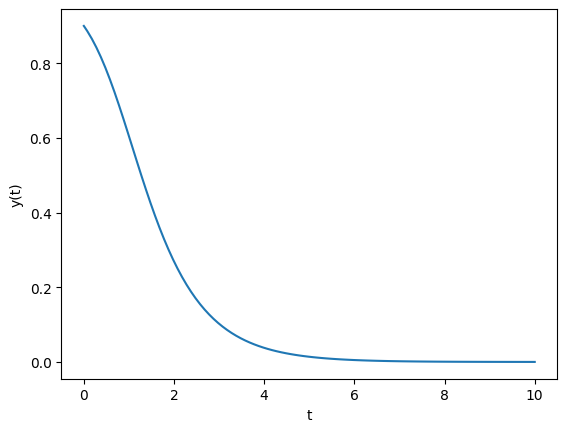

In [5]:
# simulate the continous time system we defined above and plot the results
import matplotlib.pyplot as plt
#create a simple block diagram containing our system

builder=DiagramBuilder()
system=builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

#set the initial conditions 
context=diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')




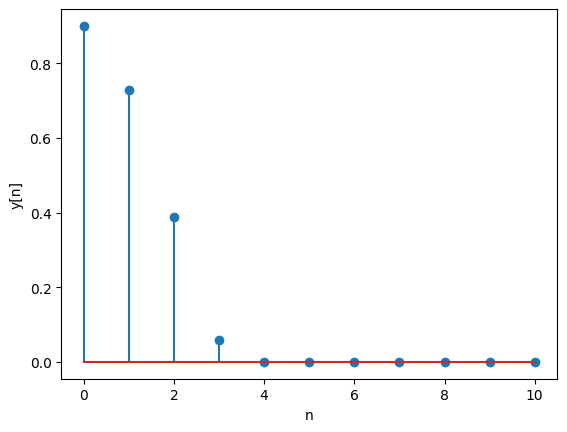

In [6]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleDiscreteTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

#set the initial conditions 
context=diagram.CreateDefaultContext()
context.SetDiscreteState([0.9])

# Create the simulator.
simulator = Simulator(diagram,context=context)

# Simulate for 10 seconds.
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(simulator.get_context())
plt.figure()
plt.stem(log.sample_times(), log.data().transpose())
plt.xlabel('n')
plt.ylabel('y[n]');

## Combinations of Systems: Diagram and DiagramBuilder

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

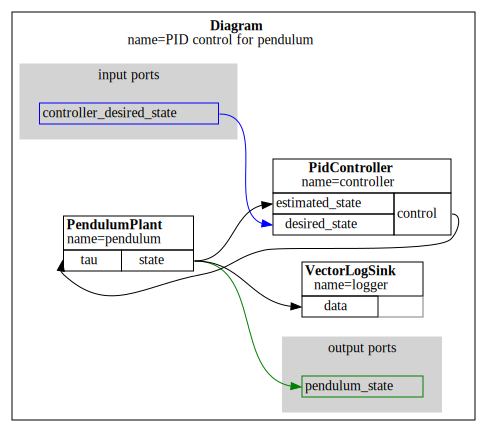

In [8]:
builder = DiagramBuilder()
# First add the pendulum.
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller.
controller = builder.AddNamedSystem("controller",
                                    PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant.
builder.Connect(pendulum.get_state_output_port(),
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())


# Make the desired_state input of the controller an input to the diagram.
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an output from the diagram.
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum.
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("PID control for pendulum")

# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


### Simulating the PID controller with pendulum

In [9]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# We'll try to regulate the pendulum to a particular angle.
desired_angle = np.pi/2.

# First we extract the subsystem context for the pendulum.
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
# Then we can set the pendulum state, which is (theta, thetadot).
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2])

# The diagram has a single input port (port index 0), which is the desired_state.
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger only because we've written this notebook with the opportunity to
# simulate multiple times (in this cell) using the same logger object.  This is
# often not needed.
logger.FindMutableLog(context).Clear()

# Simulate for 10 seconds.
simulator.AdvanceTo(20);

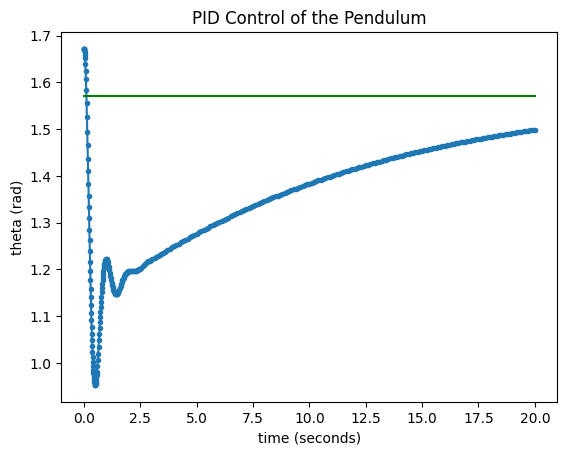

In [10]:
# Plot the results.
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
# Draw a line for the desired angle.
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum');